In [4]:
import os, sys, json
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from collections import defaultdict
from tabulate import tabulate
from IPython.core.display import display, HTML

# Increase display width
display(HTML("<style>.container { width:80% !important; }</style>"))

# Some styling
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 10

In [5]:
# We reuse these over and over and it's easier to have them in a list than unordered dict
model_names = ["wgan", "wgpgan", "nsgan", "mmgan", "ragan", 
               "lsgan", "dragan", "began", "infogan", "fishergan", 
               "fgan_forward_kl", "fgan_reverse_kl", "fgan_jensen_shannon",
               "fgan_total_var", "fgan_hellinger", "fgan_pearson"]
distance_metrics=["KL-Divergence", "Jensen-Shannon", "Wasserstein-Distance"]#, "Energy-Distance"]
distributions=['normal', 'beta', 'gumbel', 'laplace', 'exponential', 'gamma']

# Colors
palette = ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a", "#d62728", "#ff9896", "#9467bd",
            "#c5b0d5", "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", "#c7c7c7", "#bcbd22" "#dbdb8d",
            "#17becf", "#9edae5"]

# For subplotting
plt_idx = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

def get_confidence_intervals_multivariate(mypath):

    # Get file path and files therein
    files = os.listdir(mypath)
    results = []

    # Load files
    for file in files:

        if file == '.DS_Store':
            continue

        with open("{}/{}".format(mypath, file)) as f:
            data = json.load(f)
        
        results.append(data)
    
    # Get values for best runs
    optimal = nested_pickle_dict()
    for result in results:
        for model, distributions in result.items():
            for distribution, metrics in distributions.items():
                for metric, values in metrics.items():
                    if metric not in optimal[model][distribution]:
                        optimal[model][distribution][metric] = {'values': [], "parameters": []}
                    
                    if metric not in ['DLoss', 'GLoss', "LR", "HDIM", "BSIZE"]:
                        # Note we are excluding these metrics for space
                        optimal[model][distribution][metric]['values'].append(values['value'])
                        optimal[model][distribution][metric]["parameters"].append(values["parameters"])

    # Compute 5th and 95th percentiles for each epoch
    for result in results:
        for model, distributions in result.items():
            for distribution, metrics in distributions.items():
                for metric, values in metrics.items():
                    if metric not in ['DLoss', 'GLoss']:
                        data = np.column_stack(optimal[model][distribution][metric]['values'])
                        mean, h, low, high = mean_confidence_interval(data)
                        optimal[model][distribution][metric]['low'] = list(low)
                        optimal[model][distribution][metric]['h'] = h
                        optimal[model][distribution][metric]['mean'] = list(mean)
                        optimal[model][distribution][metric]['high'] = list(high)
                    
                        
    return optimal

    
def graph_multivariate(optimal, 
                       omit_outliers=True,
                       thresh=8.5,
                       plt_idx=plt_idx,
                       model_names=model_names,
                       distance_metrics=distance_metrics,
                       distributions=distributions,
                       palette=palette):
    
    for metric in distance_metrics:

        fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(20,20))

        for d_idx, distribution in enumerate(distributions):

            for idx, model_name in enumerate(model_names):

                if model_name in ['vae', 'autoencoder']:
                    continue
                    
                data = optimal[model_name][distribution][metric]['mean']
                
                if omit_outliers:
                    # Remove outliers
                    data = np.array(data)
                    notnan_indexes = ~np.isnan(data)
                    no_outliers = data.flatten()[~is_outlier(data[notnan_indexes], thresh=thresh)]

                    axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].plot(np.linspace(1, data.shape[0]+1, no_outliers.shape[0]),
                                                                     no_outliers,
                                                                     label=model_name,
                                                                     c=palette[idx])
                    
                else:

                    axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].plot(range(1, len(data)+1),
                                                                     data,
                                                                     c=palette[idx],
                                                                     label=model_name)
                
                axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].set_title("{0}".format(distribution.capitalize()))
            
            
        fig.suptitle("{0}".format(metric), fontsize=22)
        fig.text(0.5, 0.04, "Epoch", ha='center', fontsize=18)
        plt.legend(loc='center left', bbox_to_anchor=(1, 1), fontsize=18)
        plt.show()
#         plt.savefig('../graphs/multivariate/{0}_{1}_{2}.png'.format(metric, dims, samples), dpi=100)

            
def mean_confidence_interval(data, axis=1, confidence=0.95):
    try:
        n = data.shape[axis]
    except IndexError:
        axis = 0
        n = data.shape[axis]

    mu, std = np.nanmean(data, axis=axis), scipy.stats.sem(data, axis=axis, nan_policy='omit')
    h = np.ma.getdata(std) * scipy.stats.t.ppf((1 + confidence) / 2., n-1)       

    return mu, h, mu-h, mu+h


def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


def nested_pickle_dict():
    """ Picklable defaultdict nested dictionaries """
    return defaultdict(nested_pickle_dict)

In [6]:
optimal_1000 = get_confidence_intervals_multivariate("/Users/sob/Desktop/gan_results/best/multivariate/128_dims_1000_samples/")
# optimal_10000 = get_confidence_intervals_multivariate("/Users/sob/Desktop/gan_results/best/multivariate/128_dims_10000_samples/")
# optimal_100000 = get_confidence_intervals_multivariate("/Users/sob/Desktop/gan_results/best/multivariate/128_dims_100000_samples/")

In [9]:
len(optimal_1000['mmgan']['beta']['KL-Divergence']['values'])

20

In [4]:
print(""" Plot mean performance across epochs for 1k samples""")
# graph_multivariate(optimal_1000, omit_outliers=False, thresh=4.5)

 Plot mean performance across epochs for 1k samples


In [5]:
print(""" Plot mean performance across epochs for 10k samples""")
# graph_multivariate(optimal_10000, omit_outliers=True, thresh=4.5)

 Plot mean performance across epochs for 10k samples


In [6]:
print(""" Plot mean performance across epochs for 100k samples""")
# graph_multivariate(optimal_100000, omit_outliers=True, thresh=4.5)

 Plot mean performance across epochs for 100k samples


In [27]:
print(""" Print confidence intervals for minimum across all runs """)
rankings_dict = nested_pickle_dict()
param_dict = nested_pickle_dict()

for metric in distance_metrics:
    
    print('\n======================')
    print('{0}'.format(metric))
    print('======================\n')
        
    for samples, optimal in [(1000, optimal_1000), (10000, optimal_10000), (100000, optimal_100000)]:
        
        print('\n{0} Samples \n'.format(samples))

        for distribution in distributions:

            for model_name in model_names:
                
                minimums = np.nanmin(np.array(optimal[model_name][distribution][metric]['values']), axis=1)
                mu, h, low, high = mean_confidence_interval(minimums)
                param_dict[metric][model_name][distribution][samples] = '%.3f ± %.3f' % (np.round(mu, 3), np.round(h, 3))
        
        data = [[key, param_dict[metric][key]['normal'][samples], param_dict[metric][key]['beta'][samples], 
                      param_dict[metric][key]['gumbel'][samples], param_dict[metric][key]['laplace'][samples], 
                      param_dict[metric][key]['exponential'][samples], param_dict[metric][key]['gamma'][samples]]
                 for key in model_names]
        print(tabulate(data, headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma'], tablefmt='fancy_grid'), '\n')
        
        rankings = np.argsort([[eval(i[:4]) if i[:4] != 'nan ' else 1e10 for i in j[1:]] for j in data], axis=0)
        
        for j in range(rankings.shape[1]):
            for idx, name in enumerate(rankings[:, j]):
                if model_names[name] not in rankings_dict[metric][distributions[j]]:
                    rankings_dict[metric][distributions[j]][model_names[name]] = []
                rankings_dict[metric][distributions[j]][model_names[name]].append(idx)

 Print confidence intervals for minimum across all runs 

KL-Divergence


1000 Samples 

╒═════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│ Model               │ Normal        │ Beta          │ Gumbel        │ Laplace       │ Exponential   │ Gamma         │
╞═════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ wgan                │ 0.950 ± 0.069 │ 0.530 ± 0.016 │ 0.259 ± 0.019 │ 1.234 ± 0.059 │ 0.715 ± 0.013 │ 0.342 ± 0.015 │
├─────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ wgpgan              │ 1.661 ± 0.112 │ 0.728 ± 0.053 │ 0.778 ± 0.057 │ 2.398 ± 0.096 │ 0.991 ± 0.029 │ 0.503 ± 0.027 │
├─────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ nsgan               │ 0.983 ± 0.078 │ 0.807 ± 0.038 │ 0.208 ± 0.028 │

╒═════════════════════╤═════════════════╤════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╕
│ Model               │ Normal          │ Beta           │ Gumbel          │ Laplace         │ Exponential     │ Gamma           │
╞═════════════════════╪═════════════════╪════════════════╪═════════════════╪═════════════════╪═════════════════╪═════════════════╡
│ wgan                │ 17.978 ± 1.034  │ 56.765 ± 1.308 │ 44.424 ± 3.104  │ 48.813 ± 3.253  │ 65.477 ± 5.201  │ 20.111 ± 1.302  │
├─────────────────────┼─────────────────┼────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ wgpgan              │ 38.204 ± 2.090  │ 58.080 ± 1.670 │ 71.896 ± 4.725  │ 82.581 ± 3.128  │ 102.267 ± 3.833 │ 24.414 ± 1.277  │
├─────────────────────┼─────────────────┼────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ nsgan               │ 17.533 ± 1.185  │ 68.558 ± 1.879 │ 46.702 ± 4.421  │ 47.307

In [33]:
print(""" Print confidence intervals for minimum across all runs """)

for metric in distance_metrics:
    
    print('\n======================')
    print('{0}'.format(metric))
    print('======================\n')
                
    for distribution in distributions:
        
        for model_name in model_names:
            
            param_dict[metric][model_name][distribution]['performance'] = ''
        
            for samples, optimal in [(1000, optimal_1000), (10000, optimal_10000), (100000, optimal_100000)]:
                        
                minimums = np.nanmin(np.array(optimal[model_name][distribution][metric]['values']), axis=1)
                mu, h, low, high = mean_confidence_interval(minimums)
                param_dict[metric][model_name][distribution]['performance'] += '%.3f ± %.3f\n' % (np.round(mu, 3), np.round(h, 3))
        
    data = [[key, param_dict[metric][key]['normal']['performance'], param_dict[metric][key]['beta']['performance'], 
                  param_dict[metric][key]['gumbel']['performance'], param_dict[metric][key]['laplace']['performance'], 
                  param_dict[metric][key]['exponential']['performance'], param_dict[metric][key]['gamma']['performance']]
             for key in model_names]
    print(tabulate(data, headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma'], tablefmt='fancy_grid'), '\n')

 Print confidence intervals for minimum across all runs 

KL-Divergence

╒═════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│ Model               │ Normal        │ Beta          │ Gumbel        │ Laplace       │ Exponential   │ Gamma         │
╞═════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ wgan                │ 0.950 ± 0.069 │ 0.530 ± 0.016 │ 0.259 ± 0.019 │ 1.234 ± 0.059 │ 0.715 ± 0.013 │ 0.342 ± 0.015 │
│                     │ 0.929 ± 0.083 │ 0.515 ± 0.021 │ 0.259 ± 0.018 │ 1.242 ± 0.052 │ 0.719 ± 0.015 │ 0.297 ± 0.021 │
│                     │ 1.133 ± 0.097 │ 0.457 ± 0.025 │ 0.236 ± 0.015 │ 1.223 ± 0.086 │ 0.663 ± 0.035 │ 0.266 ± 0.015 │
├─────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ wgpgan              │ 1.661 ± 0.112 │ 0.728 ± 0.053 │ 0.778 ± 0.057 │ 2.398 ± 0.096 │

╒═════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│ Model               │ Normal        │ Beta          │ Gumbel        │ Laplace       │ Exponential   │ Gamma         │
╞═════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ wgan                │ 0.123 ± 0.008 │ 0.112 ± 0.003 │ 0.072 ± 0.003 │ 0.206 ± 0.008 │ 0.163 ± 0.011 │ 0.080 ± 0.004 │
│                     │ 0.135 ± 0.010 │ 0.110 ± 0.004 │ 0.068 ± 0.003 │ 0.234 ± 0.009 │ 0.159 ± 0.008 │ 0.069 ± 0.004 │
│                     │ 0.243 ± 0.021 │ 0.101 ± 0.004 │ 0.064 ± 0.002 │ 0.310 ± 0.010 │ 0.107 ± 0.005 │ 0.066 ± 0.003 │
├─────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ wgpgan              │ 0.196 ± 0.012 │ 0.132 ± 0.004 │ 0.123 ± 0.006 │ 0.308 ± 0.009 │ 0.220 ± 0.007 │ 0.094 ± 0.004 │
│                     │ 0.275 ± 0.008 │ 

In [34]:
print(""" Get relative ranking performance based on mean minimum performance\n """)


print('0 is the best performance.\n1st entry: 1k samples, 2nd: 10k, 3rd: 100k \n')
for metric in distance_metrics:
    print('========{0}=======\n'.format(metric))
    
    print(tabulate([[key, rankings_dict[metric]['normal'][key], rankings_dict[metric]['beta'][key], rankings_dict[metric]['gumbel'][key],
                          rankings_dict[metric]['laplace'][key], rankings_dict[metric]['exponential'][key], rankings_dict[metric]['gamma'][key]] 
                    for key in model_names], 
                   headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma']), '\n')

 Get relative ranking performance based on mean minimum performance
 
0 is the best performance.
1st entry: 1k samples, 2nd: 10k, 3rd: 100k 

========KL-Divergence=======

Model                Normal        Beta          Gumbel        Laplace       Exponential    Gamma
-------------------  ------------  ------------  ------------  ------------  -------------  ------------
wgan                 [3, 3, 6]     [0, 1, 0]     [6, 6, 5]     [6, 6, 5]     [0, 0, 0]      [0, 0, 0]
wgpgan               [11, 11, 10]  [5, 2, 1]     [12, 9, 8]    [12, 10, 9]   [10, 5, 1]     [7, 1, 1]
nsgan                [4, 4, 4]     [8, 6, 4]     [4, 3, 3]     [4, 3, 4]     [4, 10, 5]     [2, 4, 3]
mmgan                [14, 13, 15]  [14, 11, 12]  [13, 12, 9]   [13, 13, 15]  [15, 11, 2]    [15, 14, 12]
ragan                [9, 9, 11]    [11, 14, 14]  [8, 8, 14]    [10, 9, 11]   [5, 13, 11]    [9, 10, 13]
lsgan                [12, 12, 13]  [12, 7, 6]    [10, 11, 10]  [7, 12, 14]   [11, 14, 3]    [10, 13, 4]
dragan

 Plot mean minimum performance with error bars as a function of number samples 


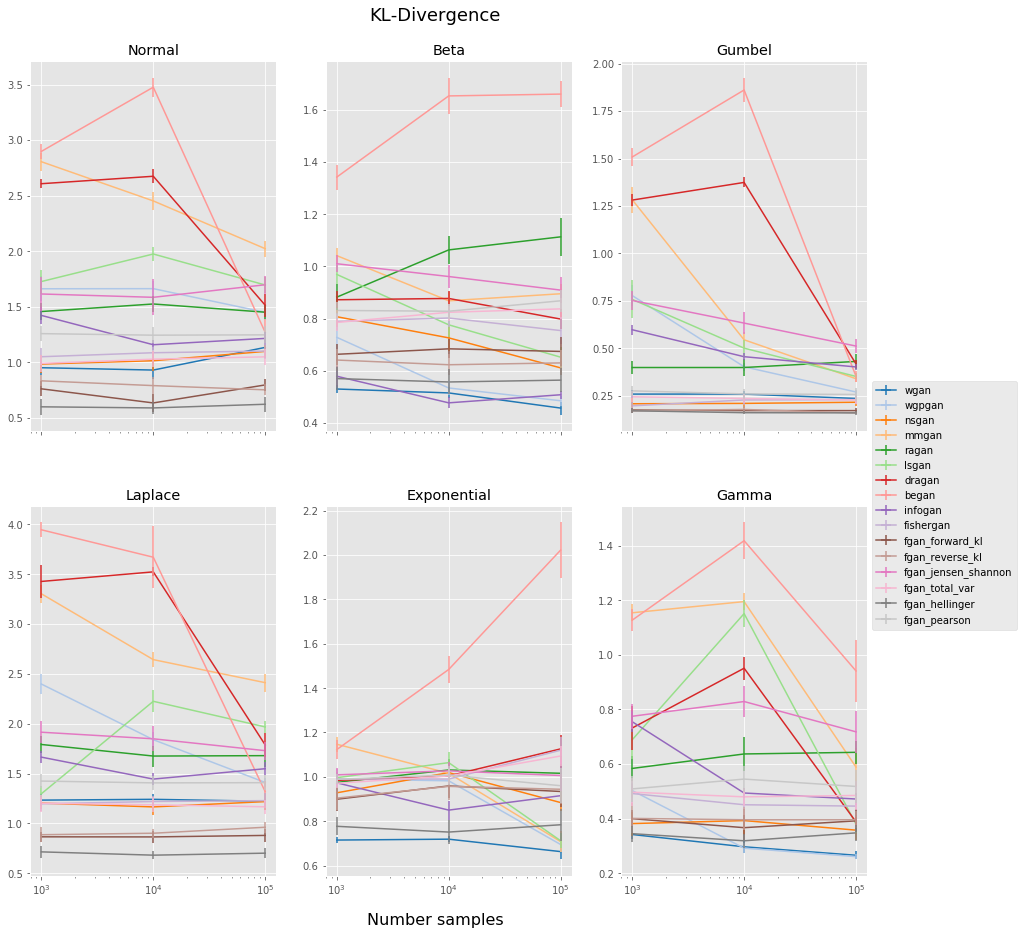

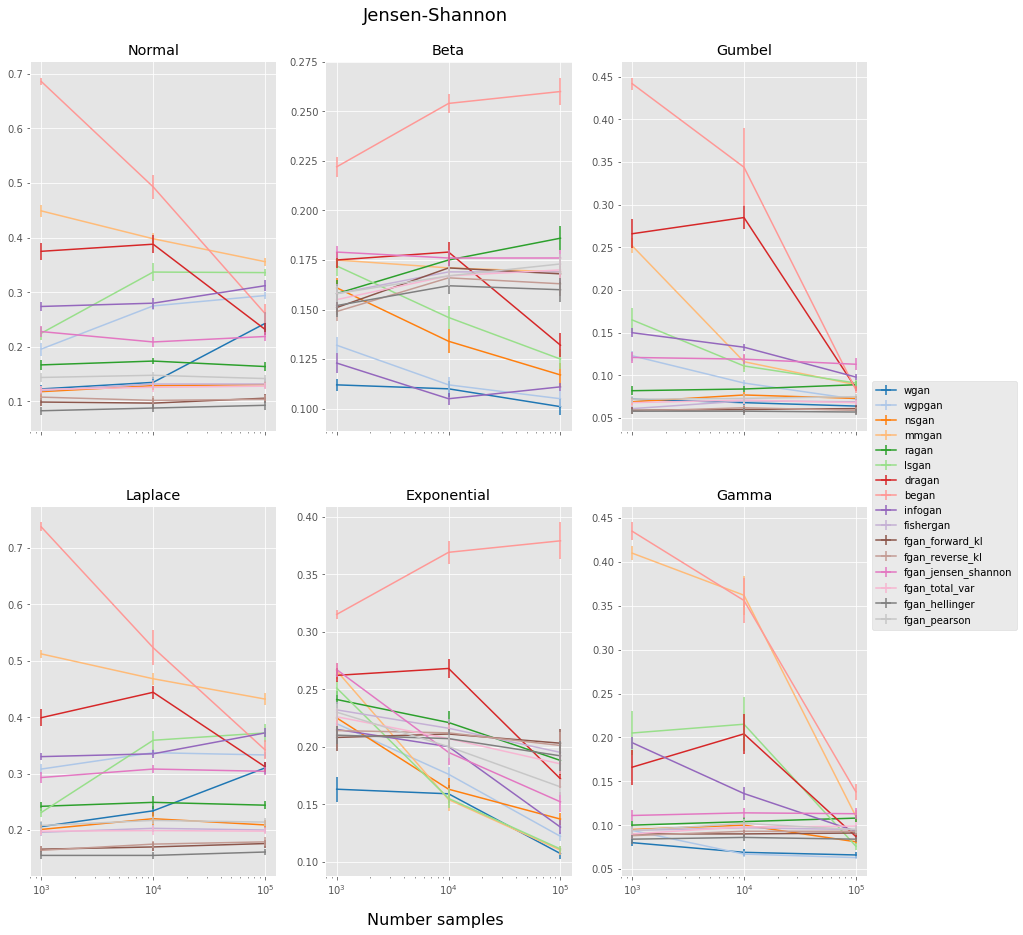

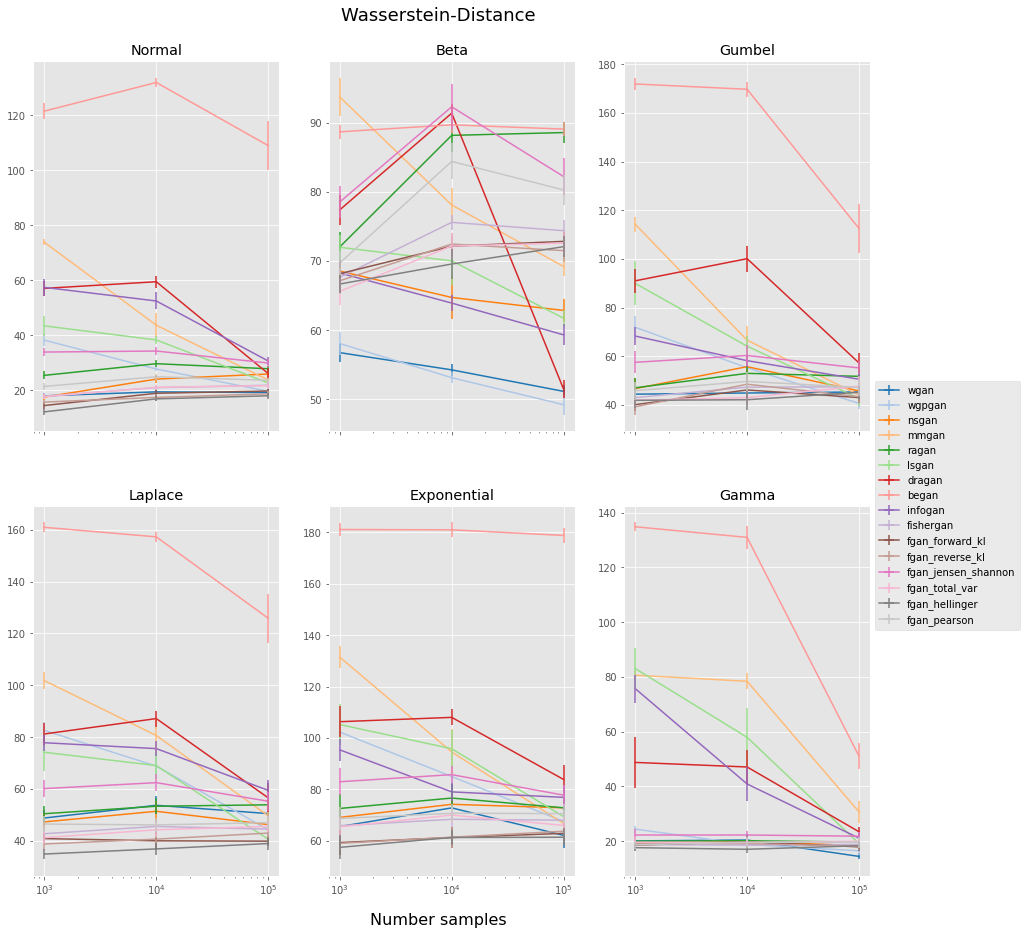

In [55]:
print(""" Plot mean minimum performance with error bars as a function of number samples """)

for metric in distance_metrics:
    
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(15,15))
                
    for d_idx, distribution in enumerate(distributions):

        for idx, model_name in enumerate(model_names):

            x, y, yerr = [], [], []
            for key, val in param_dict[metric][model_name][distribution].items():
                if key == 'performance':
                    continue

                mu, err = val.split('±')
                x.append(float(key)), y.append(float(mu)), yerr.append(float(err))

            axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].errorbar(x, y, xerr=0, yerr=yerr,
                                                                  barsabove=True, label=model_name,
                                                                  c=palette[idx], ecolor=palette[idx])
            axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].set_title("{0}".format(distribution.capitalize()))

    plt.xscale('log')
    fig.suptitle("{0}".format(metric), x=0.5, y=0.93, fontsize=18)
    fig.text(0.5, 0.08, "Number samples", ha='center', fontsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    plt.savefig('../graphs/multivariate/samplesfnc_{0}_{1}_.png'.format(metric, 128), dpi=100)
    plt.show()
    print('\n')

In [13]:
print(""" Get number of different hyperparameters for each minimum run """)
print('1st entry: 1k samples, 2nd: 10k, 3rd: 100k')

for metric in distance_metrics:
    
    print('\n======================')
    print('{0}'.format(metric))
    print('======================\n')
    
    param_dict = nested_pickle_dict()
        
    for samples, optimal in [(1000, optimal_1000), (10000, optimal_10000), (100000, optimal_100000)]:
        
        for distribution in distributions:
            
            for model_name in model_names:
                if distribution not in param_dict[model_name]:
                    param_dict[model_name][distribution] = []
                param_dict[model_name][distribution].append(len(set([tuple(t) for t in optimal[model_name][distribution][metric]['parameters']])))

    print(tabulate([[key, param_dict[key]['normal'], param_dict[key]['beta'], param_dict[key]['gumbel'],
                          param_dict[key]['laplace'], param_dict[key]['exponential'], param_dict[key]['gamma']]
                     for key in model_names],
                    headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma']))

 Get number of different hyperparameters for each minimum run 
1st entry: 1k samples, 2nd: 10k, 3rd: 100k

KL-Divergence

Model                Normal        Beta         Gumbel      Laplace       Exponential    Gamma
-------------------  ------------  -----------  ----------  ------------  -------------  ------------
wgan                 [14, 12, 10]  [5, 3, 4]    [5, 10, 5]  [14, 9, 9]    [10, 9, 10]    [11, 9, 7]
wgpgan               [5, 7, 7]     [3, 3, 3]    [6, 5, 2]   [4, 5, 4]     [8, 8, 10]     [11, 5, 6]
nsgan                [9, 7, 8]     [9, 4, 4]    [5, 8, 7]   [8, 5, 6]     [9, 10, 12]    [11, 8, 12]
mmgan                [8, 6, 4]     [3, 4, 5]    [6, 4, 5]   [7, 4, 2]     [5, 7, 10]     [5, 3, 7]
ragan                [11, 12, 10]  [6, 9, 10]   [9, 9, 13]  [13, 13, 11]  [8, 4, 4]      [12, 9, 11]
lsgan                [5, 4, 3]     [5, 7, 6]    [3, 4, 5]   [2, 7, 4]     [8, 7, 7]      [4, 6, 8]
dragan               [8, 6, 9]     [6, 4, 9]    [5, 4, 6]   [11, 6, 8]    [7, 4, 